# Assignment
 __Activity tracker analysis__ 
 Philipp Kaltofen 1839909
 
 ### Introduction
 For this assignment, we are going to explore data from activity trackers. Activity trackers are applications that track your activity using your smartphone, a smartwatch, wrist band or a clip-on device. Popular applications include Steps (iPhone), Apple Watch, Fitbit and Jawbone. For a study Links to an external site.in France, over 900 volunteers received a Fitbit Zip (a clip-on activity tracker) and recorded their daily steps, distance and calories.

### Data Cleaning

In [1]:
# library imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

C:\Users\pkalt\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\pkalt\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\pkalt\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

In [2]:
# import csv files
dfSteps = pd.read_csv("steps.csv", sep=";")
dfSurvey = pd.read_csv("survey.csv")

In [3]:
# change NaNs to 0
# dfSteps = dfSteps.fillna(0)

In [4]:
# drop rows where weight seems sus
dfSurvey = dfSurvey.drop(dfSurvey[dfSurvey["weight"] > 200].index)
dfSurvey = dfSurvey.drop(dfSurvey[dfSurvey["weight"] < 40].index)

In [5]:
# merge dataframes into one
df = pd.merge(dfSurvey, dfSteps, on = 'id')

In [6]:
# calculate mean steps per participant
meanSeries = dfSteps.mean(axis=1)

# describe (overall mean etc.)
print("Describe: ", meanSeries.describe())

# convert to dataframe and show head
mean = pd.DataFrame(dfSteps.mean(axis=1))
mean.reset_index(drop=True)
print("Mean: ", mean.head())

Describe:  count       929.000000
mean       6810.287426
std        6474.655225
min          18.000000
25%        4366.461538
50%        6078.955000
75%        8258.218045
max      168225.666667
dtype: float64
Mean:                0
0  10144.048193
1   5652.756098
2   8246.033557
3   3460.380952
4   5215.636364


### Exploratory data analysis

C:\Users\pkalt\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\pkalt\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\pkalt\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


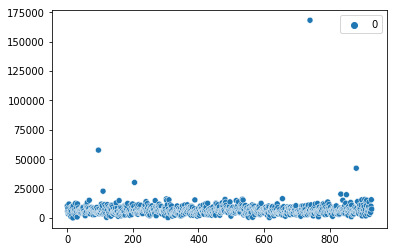

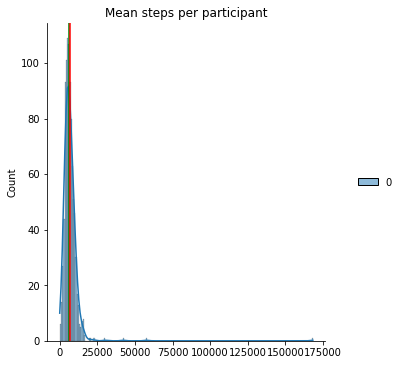

In [7]:
# get overall tendency / variation
mean_steps = mean[0].mean()
median_steps = mean[0].median()
std_steps = mean[0].std()

sns.scatterplot(data=mean)
sns.displot(data=mean, kde=True)
plt.title("Mean steps per participant")
plt.axvline(median_steps, 0, 100, color='green', label='median')
plt.axvline(mean_steps, 0, 100, color='red', label='mean')
plt.show()

##### Summary statistics

In [8]:
print("Mean steps of sample:", round(mean_steps, 2))
print("Median steps of sample:", round(median_steps, 2))
print("Standard deviation:", round(std_steps, 2))

Mean steps of sample: 6810.29
Median steps of sample: 6078.95
Standard deviation: 6474.66


The mean steps per participant data shows high normality around the mean with a slight/long right tail. There are some outliers, with a deviation between 10.000 - 150.000 steps.

##### Relation to other variables 

In [9]:
# Reindex for merge
mean = mean.reset_index()
mean = mean.rename(columns={"index": "id", 0: "mean"}) 
print(mean.head())

   id          mean
0   0  10144.048193
1   1   5652.756098
2   2   8246.033557
3   3   3460.380952
4   4   5215.636364


In [10]:
# Merge back to full dataframe
df = pd.merge(df, mean, on = 'id')

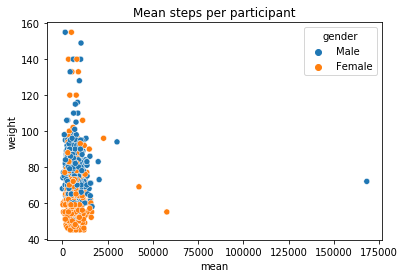

In [11]:
sns.scatterplot(data=df, x="mean", y="weight", hue="gender")
plt.title("Mean steps per participant")
plt.show()

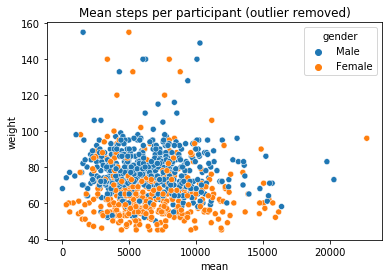

In [12]:
# Remove outlier
df = df.drop(df[df["mean"] > 25000].index)
sns.scatterplot(data=df, x="mean", y="weight", hue="gender")
plt.title("Mean steps per participant (outlier removed)")
plt.show()

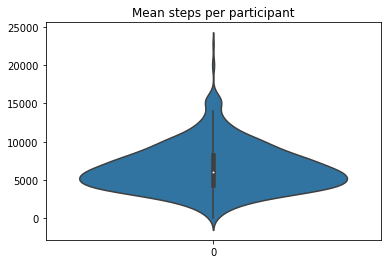

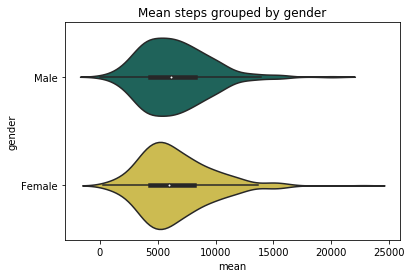

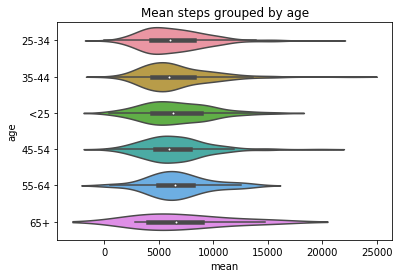

In [13]:
# Violin Plot
sns.violinplot(data=df["mean"])
plt.title("Mean steps per participant")
plt.show()

# Set custom color palette
colors = ["#136F63", "#E0CA3C", "#F34213"]
sns.set_palette(sns.color_palette(colors))

sns.violinplot(data=df, x="mean", y="gender")
plt.title("Mean steps grouped by gender")
plt.show()

sns.violinplot(data=df, x="mean", y="age")
plt.title("Mean steps grouped by age")
plt.show()

There is a higher normality in the falloff curve for male participants. Comparing different ages there is a higher variation in mean steps visible in the oldest group (65+).

### Feature engineering
*The prediction of the model can be improved by computing a variable that gives a better indication of a healthy weight than weight alone. Can you think of one? If not, just skip this step.*

In [14]:
# calculate bmi (weight in kg / (height in meter)²)
def calcBMI(weight, height):
    h = height / 100
    return weight / (h * h)

df["bmi"] = df.apply(lambda x: calcBMI(x["weight"], x["height"]), axis=1)

### Exploratory data analysis

##### Scatterplot matrix

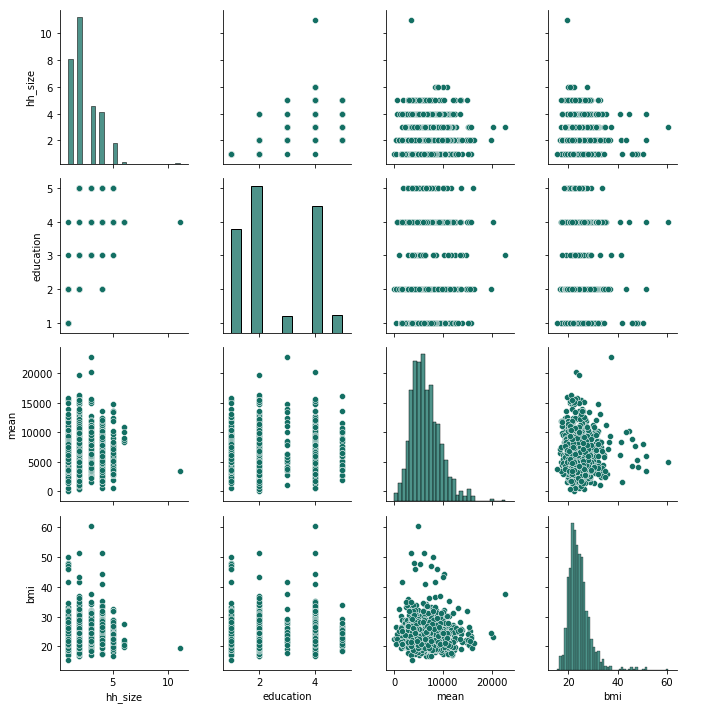

In [15]:
# scatterplot matrix of numerical variables
# age, hh_size, education, mean, bmi

dfNumericals = df[["age", "hh_size", "education", "mean", "bmi"]]
sns.pairplot(dfNumericals)

##### Correlation matrix

In [16]:
corr = dfNumericals.corr()
corr

,hh_size,education,mean,bmi
hh_size,1.000000,0.825171,0.032912,0.036676
education,0.825171,1.000000,0.041976,0.030059
mean,0.032912,0.041976,1.000000,-0.034857
bmi,0.036676,0.030059,-0.034857,1.000000


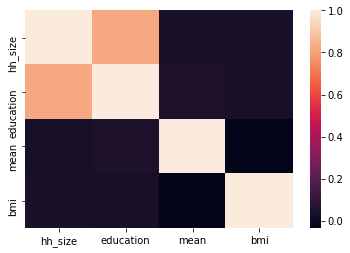

In [17]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

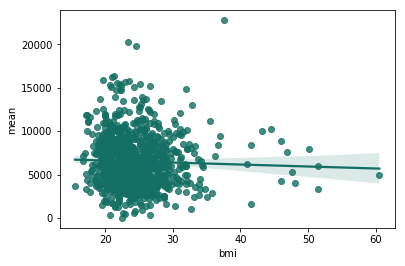

In [18]:
# Scatterplot for bmi + mean with regression line
sns.regplot(data=df, x="bmi", y="mean")

In [19]:
# drop nans in bmi and mean for calculation
dfPearson = df[["bmi", "mean"]].dropna()

# get pearson r for bmi + mean steps
r = pearsonr(dfPearson["bmi"], dfPearson["mean"])
print("r = " + str(round(r[0], 4)))
print("p < " + str(round(r[1], 4)))

r = -0.0349
p < 0.2917


The data shows little correlation on the numerical variables, although there seems to be a correlation between household size and education (r=0.82). Suprisingly, for the comparison between Body Mass Index and Mean Steps per Day there is only very little correlation (r=-0.035).

### Predictive model
Explain linear regression in your own words.
Create dummy variables for the categorical variables.
Fit a linear regression model to predict the mean steps per participant, using the training data. You can include all variables (easy), or you can try to find the combination that gives you the best fit (harder).

##### Linear regression:
Linear regression is an algorithm that calculates a function that indicates what a value will (probably) be based on its known variables. The function has linearity and can be displayed as a straight line in a coordinate system.

#### Dummy variables:

In [20]:
# categorial variables = education_1, gender, city, age
dfCategorials = df[["education_1", "gender", "city", "age"]]
dummies = pd.get_dummies(dfCategorials)

# add to dataframe
df = df.join(dummies)
df.columns

Index(['id', 'city', 'gender', 'age', 'hh_size', 'education', 'education_1',
       'height', 'weight', '20-6-2013',
       ...
       'city_Bordeaux', 'city_Lille', 'city_Lyon', 'city_Montpellier',
       'age_25-34', 'age_35-44', 'age_45-54', 'age_55-64', 'age_65+',
       'age_<25'],
      dtype='object', length=357)

In [21]:
# create sub dataframe with values for model
# dfModel = df[['mean','gender_Female', 'gender_Male', 'age_25-34', 'age_35-44', 'age_45-54', 'age_55-64', 'age_65+', 'age_<25', 'bmi']]
dfModel = df[['mean','gender_Female', 'gender_Male', 'bmi']]

dfModel = dfModel.dropna()
dfModel = dfModel.astype('float32')

# Split data
train, test = train_test_split(dfModel, test_size=0.2)

In [22]:
train.head()

,mean,gender_Female,gender_Male,bmi
852,5743.166504,0.0,1.0,24.099724
180,5200.868652,1.0,0.0,24.382374
293,8993.628906,1.0,0.0,22.761467
248,1895.347778,0.0,1.0,21.887075
846,19782.111328,0.0,1.0,24.515596


#### Linear regression model

In [23]:
# x = train[['gender_Female', 'gender_Male', 'age_25-34', 'age_35-44', 'age_45-54',  'age_55-64', 'age_65+', 'age_<25', 'bmi']]
x = train[['gender_Female', 'gender_Male', 'bmi']]
y = train['mean']

In [24]:
np.any(np.isnan(x))

False

In [25]:
lm = LinearRegression() 
lm.fit(x, y)

# print(f"The regression line is equal to y = {lm.intercept_:.3f} + {lm.coef_[0]:.3f}X + {lm.coef_[1]:.3f}X + {lm.coef_[2]:.3f}X + {lm.coef_[3]:.3f}X + {lm.coef_[4]:.3f}X + {lm.coef_[5]:.3f}X + {lm.coef_[6]:.3f}X + {lm.coef_[7]:.3f}X")

print("Intercept:", lm.intercept_)

coef = pd.DataFrame(lm.coef_, x.columns.values)
coef

Intercept: 6965.243


,0
gender_Female,-45.734474
gender_Male,45.734459
bmi,-19.414129


In [26]:
# ageCoefficients = coef.T.drop(['gender_Female', 'gender_Male', 'bmi'], axis=1)
# ageCoefficients = ageCoefficients[['age_<25', 'age_25-34', 'age_45-54',  'age_55-64', 'age_65+']]
# print(ageCoefficients)
# sns.barplot(data=ageCoefficients)

- Being a female adds 6.3 MSPD (mean steps per day), being a male lowers the MSPD roughly the same
- Being younger lowers the MSPD, until age 65, when the MSPD are increased by 1053.28
- The Body Mass Index negatively influences the mean steps per day by -20.7

Overall the coefficients seem to make sense. However, the intercept is very high with 7356.130 in relation to the slope, which could explain the small range of predictions visible in the predictions later.

In [27]:
# Use test data to predict
# x_t = test[['gender_Female', 'gender_Male', 'age_25-34', 'age_35-44', 'age_45-54',  'age_55-64', 'age_65+', 'age_<25', 'bmi']]
x_t = test[['gender_Female', 'gender_Male', 'bmi']]
test["mean_p"] = lm.predict(x_t)

print(test)

             mean  gender_Female  gender_Male        bmi       mean_p
501   9185.092773            1.0          0.0  24.167162  6450.324219
536  10009.467773            1.0          0.0  22.309357  6486.392090
638   8877.765625            0.0          1.0  27.041645  6485.987793
175  10470.034180            0.0          1.0  21.329639  6596.881348
367   8206.793945            0.0          1.0  22.724403  6569.803223
..            ...            ...          ...        ...          ...
735   6441.530762            0.0          1.0  24.691359  6531.616211
836  15054.186523            1.0          0.0  24.280975  6448.114746
364   6632.197754            0.0          1.0  24.725183  6530.959961
699   6010.926758            1.0          0.0  25.558846  6423.306152
858   5660.045410            1.0          0.0  23.323418  6466.705078

[184 rows x 5 columns]


C:\Users\pkalt\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
def calcResidual(p, t):
    return abs(p - t)

test["residual"] = test.apply(lambda x: calcResidual(x["mean_p"], x["mean"]), axis=1)
test.head()

C:\Users\pkalt\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,mean,gender_Female,gender_Male,bmi,mean_p,residual
501,9185.092773,1.0,0.0,24.167162,6450.324219,2734.768555
536,10009.467773,1.0,0.0,22.309357,6486.392090,3523.075684
638,8877.765625,0.0,1.0,27.041645,6485.987793,2391.777832
175,10470.034180,0.0,1.0,21.329639,6596.881348,3873.152832
367,8206.793945,0.0,1.0,22.724403,6569.803223,1636.990723


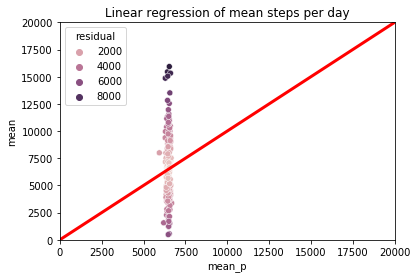

In [29]:
sns.scatterplot(data=test, x="mean_p", y="mean", hue="residual")
plt.xlim(0, 20000) 
plt.ylim(0, 20000) 
plt.plot([0, 20000], [0, 20000], color='red', lw=3)
plt.title("Linear regression of mean steps per day")
plt.show()

In [30]:
# get r²
rSqr = r2_score(test['mean'], test['mean_p'])
print(rSqr)

-0.0016034199864805032


In [31]:
math.sqrt(mean_squared_error(test['mean'], test['mean_p']))

3124.2975210437307

##### Predictive power of the model
The model is not useful to predict the mean steps per day based on the given variables. The scatterplot shows that the predictions only range between 6000 - 7000 steps per day. An explanation for the failing of this model could be, that there does not seem to be a given linearity for the case of steps per day. <br>

###### r² = -0.001

###### MSRE = 33124.29
The predictions are typically off by ~3124.29 steps per day.

### Conclusion

Data from activity trackers were analyzed on their mean steps per day, in relation to variables of the participants like Gender, Age and Weight. There was no significant correlation between the mean steps per day and any of the numerical variables. A linear regression model was trained on 80% of the data, which yielded litte results in the remaining 20% of test data.

The results of the linear regression indicate that the model is not a good fit for the data, as evidenced by the negative r² score. This could be due to the use of the wrong model or the data not being linearly related. If we look at the correlation matrix, we already see that there are almost no correlations between the independent variables and MSPD.

I tried different variables, included age and cities, but all combinations led to similar unsatisfying results.